# ML Framework For Probability of Next Pitch

In [51]:
import pandas as pd 
import numpy as np   

import seaborn as sns    
import matplotlib
import matplotlib.pyplot as plt

import sklearn
from sklearn.naive_bayes import MultinomialNB 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn import feature_extraction
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn import linear_model
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import log_loss, accuracy_score
from sklearn.preprocessing import  RobustScaler, StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
import category_encoders as ce   
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.metrics import precision_recall_curve, f1_score
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

pd.set_option('Display.max_rows',None)
pd.set_option('Display.max_columns',None)
pd.set_option('display.width', 1000)

In [17]:
df = pd.read_table('/Users/andrewmelendez/Desktop/pitches_folder/pitches', sep = ',')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 718961 entries, 0 to 718960
Columns: 125 entries, uid to modified_by
dtypes: float64(80), int64(25), object(20)
memory usage: 685.7+ MB


### Creating functions that will take care of data processing

In [18]:
# Immediately dropping data the has been null all season
def initial_column_drop(dataframe):
    drop_columns = ['runner1_id','runner1_start', 'runner1_end','runner1_event','runner1_score','runner1_rbi','runner1_earned',    
                    'runner2_id','runner2_start','runner2_end','runner2_event','runner2_score','runner2_rbi','runner2_earned',
                    'runner3_id','runner3_start','runner3_end','runner3_event','runner3_score','runner3_rbi','runner3_earned',
                    'runner4_id','runner4_start','runner4_end','runner4_event','runner4_score','runner4_rbi','runner4_earned',
                    'runner5_id','runner5_start','runner5_end','runner5_event','runner5_score','runner5_rbi','runner5_earned',
                    'runner6_id','runner6_start','runner6_end','runner6_event','runner6_score','runner6_rbi','runner6_earned',
                    'runner7_id','runner7_start','runner7_end','runner7_event','runner7_score', 'runner7_rbi', 'runner7_earned', 
                    'created_at', 'added_at', 'modified_at', 'modified_by']

    dataframe = dataframe.drop(columns = drop_columns)
    
    return dataframe

def lag_var(dataframe):
    
    dataframe[['prev_type','pitch_type','prev_pfx_x', 'prev_pfx_z','prev_spin_dir', 'prev_spin_rate']] = dataframe.groupby(['game_pk', 'team_id_b', 'team_id_p'])['type', 'pitch_type','pfx_x', 'pfx_z','spin_dir', 'spin_rate'].shift()
    
    return dataframe

def data_imputation(dataframe):
    dataframe['prev_type'] = dataframe['prev_type'].fillna(dataframe['prev_type'].mode()[0])
    dataframe['pitch_type'] = dataframe['pitch_type'].fillna(dataframe['pitch_type'].mode()[0])
    
    start_speed_median = dataframe['start_speed'].median()
    dataframe['start_speed'] = dataframe['start_speed'].fillna(value = start_speed_median)
    
    end_speed_median = dataframe['end_speed'].median()
    dataframe['end_speed'] = dataframe['end_speed'].fillna(value = end_speed_median)
    
    pfx_x_median = dataframe['pfx_x'].median()
    dataframe['prev_pfx_x'] = dataframe['prev_pfx_x'].fillna(value = pfx_x_median)
    
    pfx_z_median = dataframe['pfx_z'].median()
    dataframe['prev_pfx_z'] = dataframe['prev_pfx_z'].fillna(value = pfx_z_median)
    
    spin_dir_median = dataframe['spin_dir'].median()
    dataframe['prev_spin_dir'] = dataframe['prev_spin_dir'].fillna(value = spin_dir_median)
    
    spin_rate_median = dataframe['spin_rate'].median()
    dataframe['prev_spin_rate'] = dataframe['prev_spin_rate'].fillna(value = spin_rate_median)
    
    return dataframe

def new_features(dataframe):
    
    dataframe['runs_differential'] = abs(dataframe['away_team_runs'] - dataframe['home_team_runs'])

    return dataframe


def binary_encoding(dataframe):
    
    dataframe['stand'] = dataframe['stand'].replace({'L':0, 'R':1})
    dataframe['p_throws'] = dataframe['p_throws'].replace({'L':0, 'R':1})

    dataframe['on_1b'] = dataframe['on_1b'] * 0 + 1
    dataframe['on_1b'] = dataframe['on_1b'].fillna(0)
    dataframe['on_2b'] = dataframe['on_2b'] * 0 + 1
    dataframe['on_2b'] = dataframe['on_2b'].fillna(0)
    dataframe['on_3b'] = dataframe['on_3b'] * 0 + 1
    dataframe['on_3b'] = dataframe['on_3b'].fillna(0)

    return dataframe


def remaining_column_drop(dataframe):
    
    drop_cols = [
        'uid', 'game_pk', 'year', 'date', 'team_id_b', 'team_id_p','event', 'event2', 'event3', 'event4', 'away_team_runs', 'home_team_runs','score', 'pitch_des', 
        'pitch_id','pitch_tfs', 'pitch_tfs_zulu', 'x', 'y', 'sv_id', 'sz_top', 'sz_bot', 'start_tfs', 'start_tfs_zulu', 'is_final_pitch','final_balls','final_strikes',
        'final_outs', 'px', 'pz', 'x0', 'z0', 'y0', 'vx0', 'vz0', 'vy0', 'ax', 'az', 'ay', 'break_length', 'break_y', 'break_angle',  'type_confidence', 
        'zone', 'nasty', 'spin_dir', 'spin_rate', 'cc', 'at_bat_des', 'type', 'b_height', 'pfx_z', 'pfx_x'
        ]

    dataframe = dataframe.drop(columns = drop_cols)
    return dataframe

def data_processing(dataframe):
    df = initial_column_drop(dataframe)
    df = lag_var(df)
    df = data_imputation(df)
    df = new_features(df)
    df = binary_encoding(df)
    df = remaining_column_drop(df)
    return df 

In [19]:
df = data_processing(df)
df.head()

,inning,top,at_bat_num,pcount_at_bat,pcount_pitcher,balls,strikes,fouls,outs,batter_id,stand,pitcher_id,p_throws,start_speed,end_speed,pitch_type,on_1b,on_2b,on_3b,prev_type,prev_pfx_x,prev_pfx_z,prev_spin_dir,prev_spin_rate,runs_differential
0,1,1,1,1,1,0,0,0,0,430895,0,460024,1,88.8,81.9,FF,0.0,0.0,0.0,S,-1.66,5.81,194.447,1801.323,0
1,1,1,1,2,2,1,0,0,0,430895,0,460024,1,88.8,81.9,FF,0.0,0.0,0.0,B,-1.66,5.81,194.447,1801.323,0
2,1,1,1,3,3,2,0,0,0,430895,0,460024,1,88.8,81.9,FF,0.0,0.0,0.0,B,-1.66,5.81,194.447,1801.323,0
3,1,1,1,4,4,2,1,0,0,430895,0,460024,1,88.8,81.9,FF,0.0,0.0,0.0,S,-1.66,5.81,194.447,1801.323,0
4,1,1,2,1,5,0,0,0,1,435062,1,460024,1,88.8,81.9,FF,0.0,0.0,0.0,X,-1.66,5.81,194.447,1801.323,0


### Looking into correlations and identifying any potential for multicolinarity 

<AxesSubplot:>

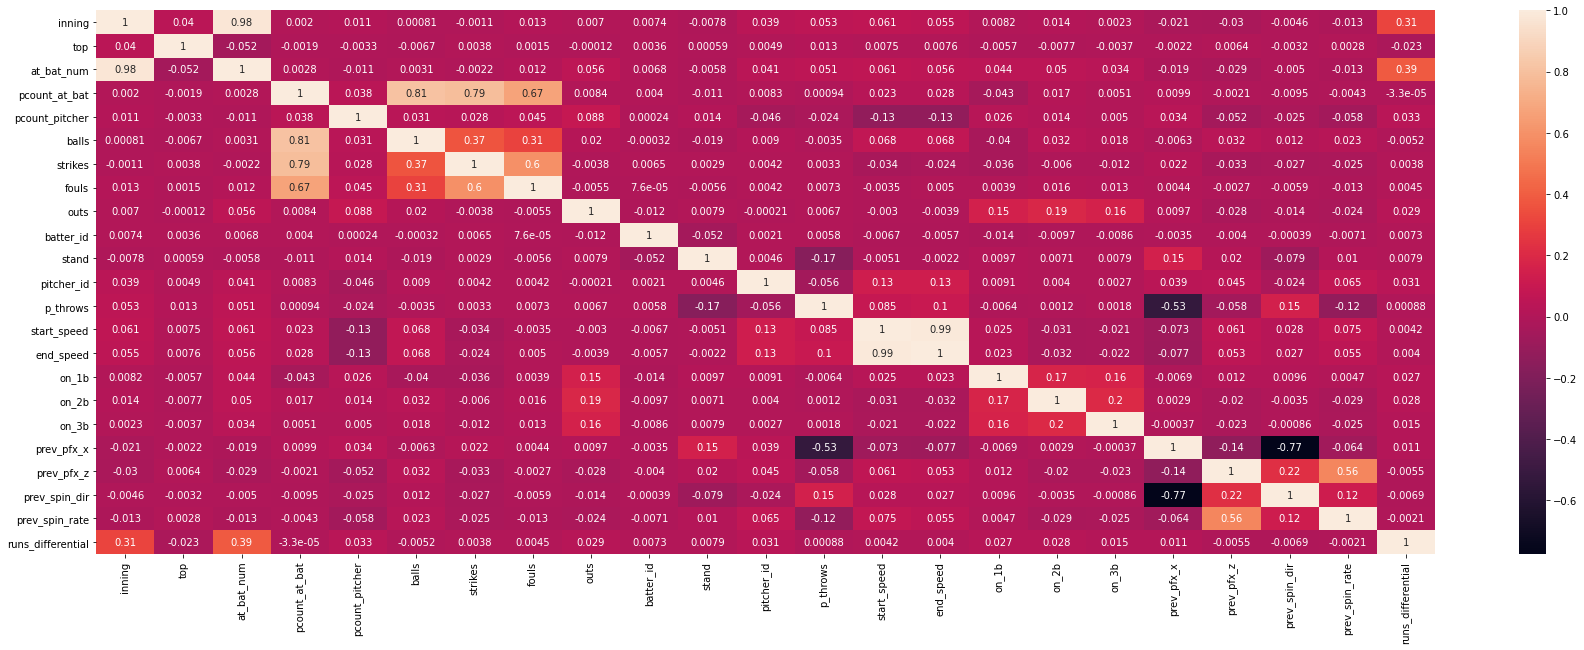

In [20]:
plt.figure(figsize=(30, 10))
sns.heatmap(df.corr(), annot=True)

### We can identify some meaningful multicolinarity, we are going to drop some columns to deal with this. We are also going to one hot encode our remaining variable.

In [21]:
df = df.drop(columns=['at_bat_num','end_speed'])
df.head()

,inning,top,pcount_at_bat,pcount_pitcher,balls,strikes,fouls,outs,batter_id,stand,pitcher_id,p_throws,start_speed,pitch_type,on_1b,on_2b,on_3b,prev_type,prev_pfx_x,prev_pfx_z,prev_spin_dir,prev_spin_rate,runs_differential
0,1,1,1,1,0,0,0,0,430895,0,460024,1,88.8,FF,0.0,0.0,0.0,S,-1.66,5.81,194.447,1801.323,0
1,1,1,2,2,1,0,0,0,430895,0,460024,1,88.8,FF,0.0,0.0,0.0,B,-1.66,5.81,194.447,1801.323,0
2,1,1,3,3,2,0,0,0,430895,0,460024,1,88.8,FF,0.0,0.0,0.0,B,-1.66,5.81,194.447,1801.323,0
3,1,1,4,4,2,1,0,0,430895,0,460024,1,88.8,FF,0.0,0.0,0.0,S,-1.66,5.81,194.447,1801.323,0
4,1,1,1,5,0,0,0,1,435062,1,460024,1,88.8,FF,0.0,0.0,0.0,X,-1.66,5.81,194.447,1801.323,0


In [30]:
X = df.drop(['pitch_type'], axis=1)
y = df['pitch_type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print('X_train shape : ', X_train.shape)
print('X_test shape : ', X_test.shape)
print('y_train shape : ', y_train.shape)
print('y_test shape : ', y_test.shape)

X_train shape :  (575168, 22)
X_test shape :  (143793, 22)
y_train shape :  (575168,)
y_test shape :  (143793,)


In [31]:
cat_encoder = ce.OneHotEncoder(cols=['prev_type'])

X_train = cat_encoder.fit_transform(X_train)
X_test = cat_encoder.transform(X_test)

In [32]:
# Scaling data for model
cols = X_train.columns
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = pd.DataFrame(X_train, columns=[cols])
X_test = pd.DataFrame(X_test, columns=[cols])

In [33]:
# Mapping lables to numeric
pitch_dict = {'AB':0, "CH":1, "CU":2, "EP":3, 'FA':4, "FC":5, "FF":6, 'FO':7, "FS":8, "FT":9, "IN":10, "KC":11, "KN":12, "PO":13, "SC":14, "SI":15, "SL":16, "UN":17} 
y_train = y_train.map(pitch_dict)
y_test = y_test.map(pitch_dict)

In [34]:
# Conveting to arrays
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

## Naive Bayes

### We start with a Gaussian Naive Bayes algorithm, this was chose due to the nature of the algorithm. The algorithm has applications of real time sustainment, it is an eager lerning classifier, fast and allows for multi class predictions. We can predict the probability of multiple classes of a our target variable (pitch type)

In [37]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
gnb_y_pred = gnb.predict(X_test)
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, gnb_y_pred)))
print('Training set score: {:.4f}'.format(gnb.score(X_train, y_train)))
print('Test set score: {:.4f}'.format(gnb.score(X_test, y_test)))

Model accuracy score: 0.4365
Training set score: 0.4351
Test set score: 0.4365


In [38]:
cross_val_score(gnb, X_train, y_train, cv=4, scoring='accuracy')

array([0.43980889, 0.4168243 , 0.43538584, 0.4333134 ])

In [39]:
print(classification_report(y_test, gnb_y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.36      0.09      0.14     14567
           2       0.71      0.66      0.68     11397
           3       0.00      0.00      0.00        30
           4       0.00      0.00      0.00        41
           5       0.41      0.20      0.27      8275
           6       0.71      0.59      0.65     48765
           7       0.02      0.21      0.04        66
           8       0.11      0.30      0.16      2077
           9       0.37      0.22      0.27     15860
          10       0.02      1.00      0.05       792
          11       0.00      0.00      0.00      1640
          12       0.25      0.59      0.35       847
          13       0.01      0.33      0.02       107
          14       0.02      0.10      0.04        30
          15       0.46      0.29      0.36     17539
          16       0.69      0.59      0.63     21756
          17       0.00    

In [40]:
gnb_y_pred_prob = gnb.predict_proba(X_test)
gnb_y_pred_prob_df = pd.DataFrame(data=gnb_y_pred_prob, columns=list(pitch_dict.keys()))
gnb_y_pred_prob_df[0:10]

,AB,CH,CU,EP,FA,FC,FF,FO,FS,FT,IN,KC,KN,PO,SC,SI,SL,UN
0,0.0,5.496152e-02,1.360076e-05,6.596917e-07,9.298655e-05,2.110109e-01,6.642376e-01,1.656367e-08,5.320942e-03,3.225731e-02,0.000000e+00,2.193695e-07,4.882308e-06,1.704731e-57,3.191143e-12,2.622154e-02,5.877882e-03,0.000000e+00
1,0.0,1.685755e-01,3.358634e-03,7.987179e-07,5.320050e-04,5.764585e-05,3.885631e-03,3.494834e-02,4.521307e-01,2.137921e-02,0.000000e+00,5.377036e-05,2.259887e-07,1.994064e-59,7.394693e-04,3.027581e-01,1.157997e-02,6.761705e-09
2,0.0,4.388204e-05,7.331269e-01,5.514112e-05,1.279396e-07,6.634388e-09,6.508374e-18,3.205810e-23,1.621332e-11,5.829027e-09,0.000000e+00,2.661711e-01,7.738151e-05,1.639225e-137,2.694165e-09,2.366062e-06,5.230937e-04,6.059526e-16
3,0.0,4.039384e-02,6.195485e-02,7.946041e-07,6.248666e-05,1.698565e-04,7.314842e-07,1.374747e-20,2.758850e-06,3.866153e-05,1.420286e-178,1.965248e-03,5.076756e-93,6.524472e-09,7.190640e-04,4.411536e-04,8.942505e-01,0.000000e+00
4,0.0,3.732024e-13,1.494652e-15,2.623413e-16,8.744205e-16,1.922996e-12,2.091643e-13,2.092089e-16,1.655146e-13,1.817044e-14,1.000000e+00,7.664640e-17,4.195021e-16,3.055591e-12,8.067817e-19,3.539252e-14,1.304397e-12,1.191182e-14
5,0.0,3.309954e-02,2.263195e-05,8.293544e-07,1.059491e-04,5.213197e-02,8.083631e-01,3.376554e-06,9.394114e-03,5.644580e-02,0.000000e+00,4.395292e-07,1.797325e-06,6.745007e-57,3.429289e-11,3.879453e-02,1.635927e-03,0.000000e+00
6,0.0,5.553427e-03,1.986310e-07,1.293816e-16,4.448612e-04,5.899765e-06,2.163515e-01,6.703901e-01,9.275522e-04,3.212335e-02,4.612134e-69,6.848044e-12,1.293669e-08,2.081319e-12,3.249790e-06,7.419615e-02,3.727400e-06,0.000000e+00
7,0.0,2.718164e-01,5.637158e-03,1.420375e-06,5.947506e-04,8.568838e-07,5.222542e-04,3.572287e-06,2.825838e-01,4.482938e-02,0.000000e+00,6.897551e-05,2.473731e-05,1.373985e-57,5.357331e-12,3.935327e-01,3.840550e-04,2.012653e-09
8,0.0,5.570870e-03,1.275973e-03,5.887376e-05,6.597348e-06,6.923524e-02,5.893824e-06,1.069267e-07,3.266791e-04,1.467196e-05,0.000000e+00,3.156997e-04,3.058643e-04,6.046679e-128,1.695306e-04,6.985258e-05,9.046292e-01,1.801493e-02
9,0.0,2.174039e-01,1.311785e-03,5.177802e-05,1.827987e-04,2.361735e-01,6.081704e-03,4.474665e-28,5.957865e-09,1.178306e-02,0.000000e+00,6.281909e-05,2.413875e-89,3.427750e-128,2.879621e-08,3.930930e-03,4.951614e-01,2.785633e-02


### Based on the results provdied above, we dont see any overfitting and consistancy within the cross validation. However, we should be able to do better than this. 

## Random Forest

In [41]:
random_forest = RandomForestClassifier(n_jobs=-1, criterion='gini', bootstrap=False)
random_forest.fit(X_train, y_train)
random_forest_y_pred = random_forest.predict(X_test)
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, random_forest_y_pred)))
print('Training set score: {:.4f}'.format(random_forest.score(X_train, y_train)))
print('Test set score: {:.4f}'.format(random_forest.score(X_test, y_test)))

Model accuracy score: 0.7828
Training set score: 1.0000
Test set score: 0.7828


In [42]:
cross_val_score(gnb, X_train, y_train, cv=4, scoring='accuracy')

array([0.43980889, 0.4168243 , 0.43538584, 0.4333134 ])

In [43]:
print(classification_report(y_test, random_forest_y_pred))

              precision    recall  f1-score   support

           1       0.75      0.69      0.72     14567
           2       0.83      0.86      0.84     11397
           3       0.00      0.00      0.00        30
           4       0.00      0.00      0.00        41
           5       0.77      0.58      0.66      8275
           6       0.82      0.91      0.86     48765
           7       0.75      0.05      0.09        66
           8       0.77      0.14      0.23      2077
           9       0.68      0.60      0.64     15860
          10       0.97      0.74      0.84       792
          11       0.95      0.36      0.53      1640
          12       0.92      0.72      0.81       847
          13       0.00      0.00      0.00       107
          14       1.00      0.20      0.33        30
          15       0.73      0.72      0.72     17539
          16       0.79      0.88      0.83     21756
          17       0.00      0.00      0.00         4

    accuracy              

In [44]:
random_forest_y_pred_prob = random_forest.predict_proba(X_test)
random_forest_y_pred_prob_df = pd.DataFrame(data=random_forest_y_pred_prob, columns=list(pitch_dict.keys()))
random_forest_y_pred_prob_df[0:10]

,AB,CH,CU,EP,FA,FC,FF,FO,FS,FT,IN,KC,KN,PO,SC,SI,SL,UN
0,0.0,0.07,0.00,0.0,0.0,0.13,0.63,0.0,0.01,0.01,0.00,0.00,0.0,0.0,0.0,0.00,0.15,0.0
1,0.0,0.07,0.00,0.0,0.0,0.00,0.10,0.0,0.02,0.07,0.00,0.00,0.0,0.0,0.0,0.74,0.00,0.0
2,0.0,0.00,0.98,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.02,0.0
3,0.0,0.00,0.09,0.0,0.0,0.02,0.00,0.0,0.00,0.00,0.00,0.06,0.0,0.0,0.0,0.00,0.83,0.0
4,0.0,0.13,0.00,0.0,0.0,0.30,0.12,0.0,0.01,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.44,0.0
5,0.0,0.01,0.00,0.0,0.0,0.00,0.99,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0
6,0.0,0.06,0.00,0.0,0.0,0.00,0.38,0.0,0.01,0.32,0.03,0.00,0.0,0.0,0.0,0.20,0.00,0.0
7,0.0,0.49,0.00,0.0,0.0,0.00,0.01,0.0,0.04,0.18,0.00,0.00,0.0,0.0,0.0,0.28,0.00,0.0
8,0.0,0.01,0.00,0.0,0.0,0.05,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.94,0.0
9,0.0,0.15,0.00,0.0,0.0,0.30,0.21,0.0,0.00,0.12,0.00,0.00,0.0,0.0,0.0,0.00,0.22,0.0


### Random Forest seems to perform slightly better but there may be some overfitting on the training data. Maybe some hyperparameter tuning will help later on. 

## AdaBoost Classifier

In [50]:
ada_boost = AdaBoostClassifier()
ada_boost.fit(X_train, y_train)
ada_boost_y_pred = ada_boost.predict(X_test)
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, ada_boost_y_pred)))
print('Training set score: {:.4f}'.format(ada_boost.score(X_train, y_train)))
print('Test set score: {:.4f}'.format(ada_boost.score(X_test, y_test)))

Model accuracy score: 0.4488
Training set score: 0.4493
Test set score: 0.4488


In [52]:
cross_val_score(ada_boost, X_train, y_train, cv=4, scoring='accuracy')

array([0.44910009, 0.44683988, 0.44993463, 0.40547457])

In [53]:
print(classification_report(y_test, ada_boost_y_pred))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00     14567
           2       0.00      0.00      0.00     11397
           3       0.00      0.00      0.00        30
           4       0.00      0.00      0.00        41
           5       0.00      0.00      0.00      8275
           6       0.60      0.90      0.72     48765
           7       0.00      0.00      0.00        66
           8       0.00      0.00      0.00      2077
           9       0.00      0.00      0.00     15860
          10       0.00      0.00      0.00       792
          11       0.00      0.00      0.00      1640
          12       0.00      0.00      0.00       847
          13       0.00      0.00      0.00       107
          14       0.00      0.00      0.00        30
          15       0.00      0.00      0.00     17539
          16       0.29      0.94      0.44     21756
          17       0.00      0.00      0.00         4

    accuracy              

In [55]:
ada_boost_y_pred_prob = ada_boost.predict_proba(X_test)
ada_boost_y_pred_prob_df = pd.DataFrame(data=ada_boost_y_pred_prob, columns=list(pitch_dict.keys()))
ada_boost_y_pred_prob_df[0:10]

,AB,CH,CU,EP,FA,FC,FF,FO,FS,FT,IN,KC,KN,PO,SC,SI,SL,UN
0,0.000020,0.072383,0.063900,0.000020,0.065584,0.071454,0.075729,0.061762,0.066965,0.073484,0.069549,0.061294,0.046759,0.066373,6.215725e-02,0.072554,0.069993,0.000020
1,0.000012,0.071313,0.071099,0.000021,0.063926,0.069709,0.070415,0.061655,0.066833,0.070774,0.066210,0.068626,0.047367,0.062791,6.613051e-02,0.070882,0.072217,0.000020
2,0.031867,0.063694,0.063931,0.056717,0.056258,0.062784,0.062759,0.057485,0.061586,0.063133,0.058984,0.061576,0.060756,0.056483,2.364130e-09,0.063754,0.064710,0.053525
3,0.000012,0.071313,0.071099,0.000021,0.063926,0.069709,0.070415,0.061655,0.066833,0.070774,0.066210,0.068626,0.047367,0.062791,6.613051e-02,0.070882,0.072217,0.000020
4,0.031867,0.063694,0.063931,0.056717,0.056258,0.062784,0.062759,0.057485,0.061586,0.063133,0.058984,0.061576,0.060756,0.056483,2.364130e-09,0.063754,0.064710,0.053525
5,0.051903,0.063146,0.056122,0.053080,0.056375,0.062860,0.065926,0.056245,0.060273,0.064027,0.060518,0.053719,0.058581,0.058317,2.170429e-09,0.063740,0.061260,0.053909
6,0.000020,0.072383,0.063900,0.000020,0.065584,0.071454,0.075729,0.061762,0.066965,0.073484,0.069549,0.061294,0.046759,0.066373,6.215725e-02,0.072554,0.069993,0.000020
7,0.031867,0.063694,0.063931,0.056717,0.056258,0.062784,0.062759,0.057485,0.061586,0.063133,0.058984,0.061576,0.060756,0.056483,2.364130e-09,0.063754,0.064710,0.053525
8,0.031867,0.063694,0.063931,0.056717,0.056258,0.062784,0.062759,0.057485,0.061586,0.063133,0.058984,0.061576,0.060756,0.056483,2.364130e-09,0.063754,0.064710,0.053525
9,0.031867,0.063694,0.063931,0.056717,0.056258,0.062784,0.062759,0.057485,0.061586,0.063133,0.058984,0.061576,0.060756,0.056483,2.364130e-09,0.063754,0.064710,0.053525


### The AdaBoost algorithm was not very impressive. We can still do better.

## Extreme Gradient Boosting 

In [45]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
xgb_y_pred = xgb.predict(X_test)
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, xgb_y_pred)))
print('Training set score: {:.4f}'.format(xgb.score(X_train, y_train)))
print('Test set score: {:.4f}'.format(xgb.score(X_test, y_test)))

Model accuracy score: 0.8969
Training set score: 0.9120
Test set score: 0.8969


In [46]:
cross_val_score(xgb, X_train, y_train, cv=4, scoring='accuracy')

array([0.89452125, 0.89363108, 0.89504979, 0.8925879 ])

In [47]:
print(classification_report(y_test, xgb_y_pred))

              precision    recall  f1-score   support

           1       0.88      0.82      0.85     14567
           2       0.94      0.91      0.92     11397
           3       0.40      0.07      0.11        30
           4       0.00      0.00      0.00        41
           5       0.88      0.81      0.85      8275
           6       0.90      0.94      0.92     48765
           7       0.93      0.82      0.87        66
           8       0.86      0.69      0.77      2077
           9       0.87      0.83      0.85     15860
          10       0.94      0.88      0.91       792
          11       0.94      0.92      0.93      1640
          12       0.95      0.96      0.95       847
          13       0.70      0.07      0.12       107
          14       0.88      0.73      0.80        30
          15       0.91      0.92      0.92     17539
          16       0.89      0.93      0.91     21756
          17       0.00      0.00      0.00         4

    accuracy              

In [48]:
xgb_y_pred_prob = xgb.predict_proba(X_test)
xgb_y_pred_prob_df = pd.DataFrame(data=xgb_y_pred_prob, columns=list(pitch_dict.keys()))
xgb_y_pred_prob_df[0:10]

,AB,CH,CU,EP,FA,FC,FF,FO,FS,FT,IN,KC,KN,PO,SC,SI,SL,UN
0,7.386278e-07,0.022019,3.891772e-05,1.787258e-07,1.406851e-04,0.026932,0.938481,2.976822e-07,0.000179,0.000451,1.346965e-06,0.000003,9.418783e-07,7.614826e-06,2.590667e-07,0.000145,0.011598,4.029453e-07
1,3.878890e-09,0.002996,2.280544e-06,3.088426e-08,1.253672e-04,0.000001,0.000459,5.874081e-06,0.000107,0.001860,1.360011e-07,0.000002,3.889235e-08,4.987377e-07,1.211141e-06,0.994206,0.000233,1.158091e-08
2,5.620892e-08,0.000189,9.783720e-01,2.583286e-05,4.526937e-06,0.000219,0.000049,5.782265e-08,0.000005,0.000365,7.221444e-08,0.001042,6.624249e-06,8.787055e-07,6.930903e-07,0.000023,0.019696,2.082142e-07
3,7.037548e-07,0.001045,2.965971e-02,2.615606e-07,1.272553e-05,0.000467,0.000545,2.303619e-05,0.001017,0.001368,1.655697e-05,0.000664,4.320316e-07,1.888458e-05,9.578671e-07,0.000094,0.965066,3.647319e-07
4,6.247191e-07,0.075056,1.093185e-03,1.190482e-06,7.017338e-05,0.648071,0.090945,2.650850e-06,0.001810,0.000296,7.282389e-05,0.000203,5.009193e-06,1.880914e-04,4.884881e-07,0.001065,0.181119,2.262556e-06
5,4.275905e-09,0.000013,2.985829e-07,7.796993e-09,5.291769e-07,0.000787,0.998774,1.989763e-09,0.000001,0.000146,1.261855e-08,0.000003,5.100110e-08,1.284981e-07,3.427631e-09,0.000168,0.000106,1.552301e-08
6,7.522227e-07,0.007016,1.414561e-06,5.999404e-07,1.048334e-04,0.000112,0.876042,2.564485e-06,0.000752,0.043479,2.797109e-05,0.000002,3.591131e-07,7.961006e-05,7.024203e-07,0.072300,0.000078,5.274680e-07
7,8.988910e-08,0.687160,4.817595e-05,1.536032e-06,1.494410e-04,0.000054,0.004321,6.266184e-07,0.015443,0.010204,2.412588e-06,0.000014,8.785410e-07,7.606015e-06,1.134425e-07,0.282349,0.000245,1.992615e-07
8,1.622119e-07,0.015210,1.173178e-02,1.147103e-05,4.951932e-05,0.317031,0.003039,4.940232e-06,0.000101,0.001112,3.516653e-05,0.000199,8.236754e-06,1.553303e-06,8.956047e-07,0.006889,0.644568,5.922322e-06
9,1.226418e-06,0.284700,3.518321e-03,1.456383e-05,3.106032e-05,0.218168,0.111863,4.101561e-06,0.000300,0.024196,2.058057e-05,0.000058,4.470636e-05,7.181485e-06,9.519617e-07,0.000584,0.356481,7.031147e-06


### The XGBoost algorithm performed exceptionally well. I have high hope the model would perform better after hyperparameter tuning and scaling. The nature of the algorithm is to be extremely fast, scalable and portable.

## Future steps : 
- Developing further model checking functions and automated model comparison functions. Introduce ROC, AUC, Error Analysis and scoring each model against each other. This would help identify model success.
- Identifying and implement additional models and hyperparameter tuning. Neural Nets seem to be a very goood fit here but had limited time to test them out in this script. Stacking models may also render a viable model. 
- Developing cutom full scale etl pipelines, unit testing, live data connection, dimension reduction.
- Adding additional feature engineering componets.
- Automate process to be scaled to live environment.
- Seperate feauture engineering to pickle file where we can create custom functions for specific use cases. 